In [23]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from jax import jacfwd, jacrev
from jax import vmap, grad, jit, random
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

from flax import nnx
import optax
import pcax

from tqdm.notebook import tqdm
from tqdm.notebook import trange

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import os
os.chdir('../methods')
import lsci, supr, conf, uqno, prob_don, quant_don, gaus
os.chdir('../gpsims')

os.chdir('../models_and_metrics')
from models import *
from metrics import * 
from utility import *
os.chdir('../gpsims')

In [40]:
kernel = jnp.ones(5)/5

n, p = 200, 50
beta = random.normal(rng, (5,))
bias = 1

### train
rng0 = 0
rng = random.PRNGKey(rng0)
key1, key2, key3 = random.split(rng, 3)

xtrain = conv(conv(random.normal(key1, (n, p)), kernel), kernel)
sigma = jnp.mean((xtrain)**2, axis = 1)[:,None]
epsilon = sigma * conv(conv(random.normal(key2, (n, p)), kernel), kernel)
ytrain = bias + conv(xtrain, beta) + epsilon

### valid
rng0 += 1
rng = random.PRNGKey(rng0)
key1, key2, key3 = random.split(rng, 3)

xval = conv(conv(random.normal(key1, (n, p)), kernel), kernel)
sigma = jnp.mean((xval)**2, axis = 1)[:,None]
epsilon = sigma * conv(conv(random.normal(key2, (n, p)), kernel), kernel)
yval = bias + conv(xval, beta) + epsilon

### valid
rng0 += 1
rng = random.PRNGKey(rng0)
key1, key2, key3 = random.split(rng, 3)

xtest = conv(conv(random.normal(key1, (n, p)), kernel), kernel)
sigma = jnp.mean((xtest)**2, axis = 1)[:,None]
epsilon = sigma * conv(conv(random.normal(key2, (n, p)), kernel), kernel)
ytest = bias + conv(xtest, beta) + epsilon

In [41]:
xtrain = xtrain[:,None]
ytrain = ytrain[:,None]
xval = xval[:,None]
yval = yval[:,None]
xtest = xtest[:,None]
ytest = ytest[:,None]

In [42]:
train_data = TensorDataset(jax2torch(xtrain), jax2torch(ytrain))
train_loader = DataLoader(train_data, batch_size = 30, shuffle = True)

In [43]:
import neuralop as op
from neuralop.models import FNO, LocalFNO, UNO, TFNO

loss_fn = nn.MSELoss()

fno = FNO(n_modes=(16,), 
             hidden_channels=64, 
             in_channels=1, 
             out_channels=1)
optim_fno = torch.optim.Adam(fno.parameters(), lr = 1e-3)

In [44]:
epochs = 20
for _ in trange(epochs):
    for xt, yt in tqdm(train_loader, leave = False):  
        yhat = fno(xt)
        loss = loss_fn(yhat, yt)
        loss.backward()
        optim_fno.step()
        optim_fno.zero_grad()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [45]:
with torch.no_grad():
    yval_fno = jnp.array(np.array(fno(jax2torch(xval)).squeeze()))
#     yval_tno = jnp.array(np.array(tno(xval).squeeze()))
#     yval_uno = jnp.array(np.array(uno(xval).squeeze()))
    ytest_fno = jnp.array(np.array(fno(jax2torch(xtest)).squeeze()))
#     ytest_tno = jnp.array(np.array(tno(xtest).squeeze()))
#     ytest_uno = jnp.array(np.array(uno(xtest).squeeze()))

In [157]:
rval_fno = yval.squeeze() - yval_fno
rtest_fno = ytest.squeeze() - ytest_fno

n = rval_fno.shape[0]
alpha = 0.1

In [158]:
# slice basis
phi = jax.random.normal(rng, (50, 100))
phi = phi / jnp.sum(phi, axis = 1)[:,None]

In [159]:
rval_phi = rval_fno @ phi
rtest_phi = rtest_fno @ phi

In [160]:
dist = jnp.mean((xval - xtest[0][None,])**2, axis = (1, 2))
w = d / jnp.sum(dist)

In [161]:
f = jnp.sum(w*(rval_phi[4,0] > rval_phi[:,0]))
depth = 1 - jnp.abs(1 - 2 * f)
depth

Array(0.92050934, dtype=float32)

In [162]:
f = jnp.sum(w[:,None] * (rval_phi[0,:] > rval_phi), axis = 0)
depth = 1 - jnp.abs(1 - 2 * f)
jnp.min(depth)

Array(0.03091925, dtype=float32)

In [177]:
def phi_tukey(z, x, w):
    f = jnp.sum(w[:,None] * (z > x), axis = 0)
    depth = 1 - jnp.abs(1 - 2 * f)
    return jnp.min(depth)

phi_tukey = jit(phi_tukey)
v_phi_tukey = jit(vmap(phi_tukey, (0, None, None)))

In [178]:
phi_tukey(rval_phi[3], rval_phi, w)

Array(0.00660461, dtype=float32)

In [198]:
s = v_phi_tukey(rval_phi, rval_phi, w)

k = int(jnp.ceil((n+1)*(1-alpha)))
q = jnp.sort(s, descending=True)[k]
q

Array(0., dtype=float32)

In [199]:
quant = jnp.ceil((n+1)*(1-alpha))/n

In [200]:
jnp.quantile(s, 1 - quant)

Array(0., dtype=float32)

In [181]:
s_test = phi_tukey(rtest_phi[0], rval_phi, w)
s_test

Array(0.02462244, dtype=float32)

In [596]:
from jax.scipy.stats import norm

### 
rng = random.PRNGKey(3)
n, p = rval_fno.shape
alpha = 0.1

rval_fno = yval.squeeze() - yval_fno
rtest_fno = ytest.squeeze() - ytest_fno

xtil = xtest[0:1] + 1e-4 * jax.random.normal(rng, xtest[0:1].shape)
dist = jnp.sqrt(jnp.mean((xval - xtil)**2, axis = (1, 2)))
w = d / jnp.sum(dist)
# w = w[:,None]


# random basis
phi = slice_phi(rng, 50, 20)
rval_phi = rval_fno @ phi
rtest_phi = rtest_fno @ phi  

x = rval_phi
z = rtest_phi[0:1]

In [616]:
def phi_norm(z, x, w):
    mu = jnp.sum(w * x[:,k])
    sig = jnp.sqrt(jnp.sum((w*x[:,k] - mu)**2))
    return 1 - jnp.abs(1 - 2 * norm.cdf(z[:,k], mu, sig))


quant = jnp.ceil((n+1)*(1-alpha))/n
depth = 1 - jnp.abs(1 - 2 * norm.cdf(z[:,k], mu, sig))
depth, norm.ppf(quant, mu, sig)

(Array([0.33132374], dtype=float32), Array(0.29665366, dtype=float32))

In [622]:
mu = jnp.sum(w[:,None] * x, axis = 0)
sig = jnp.sqrt(jnp.sum((w[:,None] * x - mu)**2, axis = 0))

1 - jnp.abs(1 - 2 * norm.cdf(z, mu, sig))

Array([[1.1205673e-05, 5.1130116e-01, 1.9396126e-02, 3.3132374e-01,
        2.2283792e-03, 1.3847864e-01, 4.9392104e-02, 1.4128476e-01,
        1.7361641e-03, 5.7287812e-03, 4.3319881e-02, 0.0000000e+00,
        7.5911498e-01, 0.0000000e+00, 4.3160677e-01, 0.0000000e+00,
        2.5452375e-03, 1.6689301e-06, 5.5585861e-02, 2.0570052e-01]],      dtype=float32)

In [594]:
from jax.scipy.stats import norm

depth = 1 - jnp.abs(1 - 2 * norm.cdf(x[:,0], mu, sig))
depth.shape

(200,)

In [595]:
norm.cdf(z[:,0], mu, sig)

Array([0.9999944], dtype=float32)

In [703]:
def phi_tukey(z, x, w):
    f = jnp.sum(w[:,None] * (z > x), axis = 0)
    depth = 1 - jnp.abs(1 - 2 * f)
    return jnp.min(depth)

phi_tukey = jit(phi_tukey)
v_phi_tukey = jit(vmap(phi_tukey, (0, None, None)))

In [715]:
### valid
rng0 = 534
rng = random.PRNGKey(rng0)
key1, key2, key3 = random.split(rng, 3)

xtest = conv(conv(random.normal(key1, (n, p)), kernel), kernel)
sigma = jnp.mean((xtest)**2, axis = 1)[:,None]
epsilon = sigma * conv(conv(random.normal(key2, (n, p)), kernel), kernel)
ytest = bias + conv(xtest, beta) + epsilon

xtest = xtest[:,None]
ytest = ytest[:,None]
with torch.no_grad():
    ytest_fno = jnp.array(np.array(fno(jax2torch(xtest)).squeeze()))

In [716]:
def slice_phi(rng, p1, p2):
    phi = jax.random.normal(rng, (p1, p2))
    phi = phi / jnp.sum(phi, axis = 1)[:,None]
    return phi

In [717]:
### 
rng = random.PRNGKey(3)
n, p = rval_fno.shape
alpha = 0.1

rval_fno = yval.squeeze() - yval_fno
rtest_fno = ytest.squeeze() - ytest_fno

In [718]:
def local_phi_inclusion(rval_phi, xval, rtest_phi, xtest):
    
    xtest_til = xtest[None,] + 1e-4 * jax.random.normal(rng, xtest[None,].shape)
    dist = jnp.sqrt(jnp.mean((xval - xtest_til)**2, axis = (1, 2)))
    w = d / jnp.sum(dist)
    
    s = v_phi_tukey(rval_phi, rval_phi, w)
    quant = jnp.ceil((n+1)*(1-alpha))/n
    q = jnp.quantile(s, 1 - quant)
    s_test = phi_tukey(rtest_phi, rval_phi, w)
    
    return s_test > q

local_phi_inclusion = jit(vmap(local_phi_inclusion, (None, None, 0, 0)))

In [733]:
# random basis
rng = random.PRNGKey(345)
phi = slice_phi(rng, 50, 10)
rval_phi = rval_fno @ phi
rtest_phi = rtest_fno @ phi 

np.mean(local_phi_inclusion(rval_phi, xval, rtest_phi, xtest))

Array(0.89, dtype=float32)

In [734]:
# wavelet basis
import jaxwt as jwt

rval_phi = jwt.wavedec(rval_fno, 'haar', mode='zero', level=2)[0]
rtest_phi = jwt.wavedec(rtest_fno, 'haar', mode='zero', level=2)[0]

np.mean(local_phi_inclusion(rval_phi, xval, rtest_phi, xtest))

Array(0.895, dtype=float32)

In [735]:
# FPCA basis
import pcax

# Fit the PCA model with 3 components on your data X
state = pcax.fit(rval_fno, n_components = 20)

rval_phi = pcax.transform(state, rval_fno)
rtest_phi = pcax.transform(state, rtest_fno)

np.mean(local_phi_inclusion(rval_phi, xval, rtest_phi, xtest))

Array(0.93, dtype=float32)

In [736]:
rval_rec = pcax.recover(state, rval_phi)

In [737]:
np.mean((rval_rec - rval_fno)**2)

Array(0.00062366, dtype=float32)

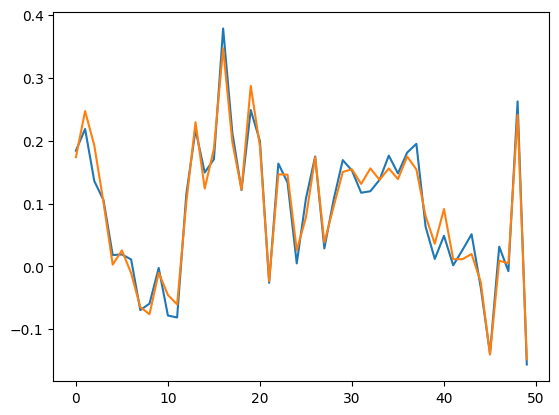

In [738]:
plt.plot(rval_fno[3])
plt.plot(rval_rec[3])

In [90]:
kernel = jnp.ones(5)/5

rng0 = 0
rng = random.PRNGKey(rng0)
key1, key2, key3 = random.split(rng, 3)

### train
n, p = 2000, 50
beta = random.normal(rng, (5,))
bias = 1

xtrain = conv(conv(random.normal(key1, (n, p)), kernel), kernel)
sigma = jnp.std(xtrain, axis = 1)
sigma = sigma - jnp.mean(sigma) + 1
sigma = sigma/sigma
epsilon = sigma[:,None] * conv(conv(random.normal(key2, (n, p)), kernel), kernel)

ytrain = bias + conv(xtrain, beta) + epsilon
xtrain = xtrain[:,None,:,None]
ytrain = ytrain[:,None,:,None]

### valid
rng0 += 1
rng = random.PRNGKey(rng0)
key1, key2, key3 = random.split(rng, 3)

xval = conv(conv(random.normal(key1, (n, p)), kernel), kernel)
sigma = jnp.std(xval, axis = 1)
sigma = sigma - jnp.mean(sigma) + 1
sigma = sigma/sigma
epsilon = sigma[:,None] * conv(conv(random.normal(key2, (n, p)), kernel), kernel)

yval = bias + conv(xval, beta) + epsilon
xval = xval[:,None,:,None]
yval = yval[:,None,:,None]


### test
ntest = 250
rng0 += 1
rng = random.PRNGKey(rng0)
key1, key2, key3 = random.split(rng, 3)

xtest = conv(conv(random.normal(key1, (ntest, p)), kernel), kernel)
sigma = jnp.std(xtest, axis = 1)
sigma = sigma - jnp.mean(sigma) + 1
sigma = sigma/sigma
epsilon = sigma[:,None] * conv(conv(random.normal(key2, (ntest, p)), kernel), kernel)

ytest = bias + conv(xtest, beta) + epsilon
xtest = xtest[:,None,:,None]
ytest = ytest[:,None,:,None]

In [91]:
train_data = TensorDataset(jax2torch(xtrain), jax2torch(ytrain))
train_loader = DataLoader(train_data, batch_size = 30, shuffle = True)

In [92]:
epochs = 100
trace = []
lag, lead = 1, 1

model = DeepANO(lag, 50, lead, rngs=nnx.Rngs(0))
optim = nnx.Optimizer(model, optax.adam(1e-3))
rng = random.PRNGKey(0)

for _ in trange(epochs):
    for xt, yt in train_loader:
        xt = torch2jax(xt)
        yt = torch2jax(yt)
        
        loss = train_step(model, optim, xt, yt)
        trace.append(loss)

model.eval()

  0%|          | 0/100 [00:00<?, ?it/s]

In [93]:
yval_hat = model(xval)
ytest_hat = model(xtest)

In [94]:
npc = 25
gamma1 = 0.1

rval = (yval - yval_hat).squeeze()
rtest = (ytest - ytest_hat).squeeze()
state = lsci.lsci_state(xval.squeeze(), rval, npc)
pca_state = state[-1]

In [95]:
def local_weights2(xval, xtest, frac = 0.1):
    dmat = jnp.max(jnp.abs(xval - xtest), axis = 1)
    quant = jnp.quantile(dmat, frac, axis = 0)
    indx = dmat < quant
    inner_max = jnp.max(dmat * indx)
    dmat = inner_max - dmat
    w = dmat * indx
    return w / jnp.sum(w, axis = 0)[None,]
local_weights2 = jit(vmap(local_weights2, (None, 0, None)))

In [96]:
xval2 = xval.squeeze()
xtest2 = xtest.squeeze()

In [97]:
w = local_weights2(xval2, xtest2, 0.1)
1/np.mean(w[0][w[0] > 0]), np.std(w)

(Array(199.00002, dtype=float32), Array(0.00198357, dtype=float32))

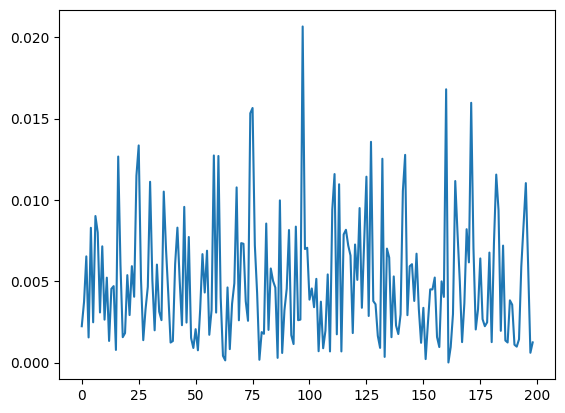

In [98]:
plt.plot(w[0][w[0] > 0])

In [80]:
w = local_weights2(xval2, xtest2, 0.2)
1/np.mean(w[w > 0]), np.std(w)

(Array(199., dtype=float32), Array(0.00267017, dtype=float32))

In [77]:
w = local_weights2(xval2, xtest2, 1.0)
np.mean(w[w > 0]), np.std(w)

(Array(0.001002, dtype=float32), Array(0.00029706, dtype=float32))

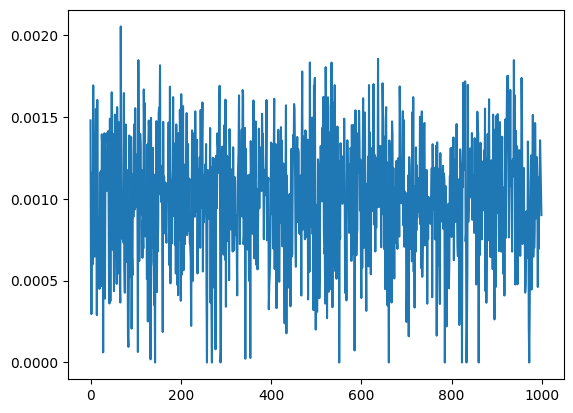

In [67]:
plt.plot(w[0])

In [49]:
npc = 25
gamma1 = 0.1
gamma2 = 0.05
alpha = 0.1
nval = xval.shape[0]

lsc1_risk, lsc1_width = [], []

rval = (yval - yval_hat).squeeze()
rtest = (ytest - ytest_hat).squeeze()
state = lsci.lsci_state(xval.squeeze(), rval, npc)
pca_state = state[-1]

for i in trange(0, ytest.shape[0]):
    
    # LSCI
    lsc1_lower, lsc1_upper = lsci.lsci_band(xtest[i].squeeze(), state, alpha, 2000, gamma1)
    lsc1_risk.append(risk(lsc1_lower, lsc1_upper, rtest[i]))
    lsc1_width.append(jnp.median(lsc1_upper - lsc1_lower))

  0%|          | 0/250 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:
nproj = npc = 50
gamma1 = 0.1
gamma2 = 0.05
alpha = 0.1
rval = (yval - yval_hat).squeeze()
rtest = (ytest - ytest_hat).squeeze()

state = lsci.lsci_state(xval, rval, npc)
pca_state = state[-1]

In [14]:
lsci_risk = []
for i in trange(500):
    lsc1_lower, lsc1_upper = lsci.lsci_band(xtest[i].squeeze(), state, alpha, 2000, gamma2)
    lsci_risk.append(risk(lsc1_lower, lsc1_upper, rtest[i]))

  0%|          | 0/500 [00:00<?, ?it/s]

In [15]:
np.mean(np.array(lsci_risk) >= 0.99)

0.906

In [16]:
lsci_risk = []
for i in trange(500):
    lsc1_lower, lsc1_upper = lsci.lsci_band(xtest[i].squeeze(), state, alpha, 2000, gamma1)
    lsci_risk.append(risk(lsc1_lower, lsc1_upper, rtest[i]))

  0%|          | 0/500 [00:00<?, ?it/s]

In [19]:
np.mean(np.array(lsci_risk) >= 0.99)

0.914

In [23]:
lsc1_ens = lsci.lsci(xtest[0].squeeze(), state, alpha, 2000, gamma1)

In [39]:
nsamp = 2000
npc = 50
alpha = 0.1

rval = (yval - yval_hat).squeeze()

xval = xval.squeeze()
rval = rval.squeeze()
xtest = xtest.squeeze()
state = lsci.lsci_state(xval, rval, npc)

In [40]:
lsc1_ens = lsci.lsci(xtest[0].squeeze(), state, alpha, 2000, gamma1)
lsc1_ens.shape

(2000, 100)

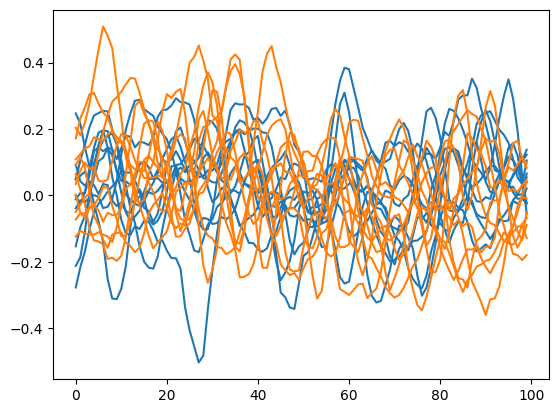

In [41]:
plt.plot(lsc1_ens[0:10].T, c='C0')
plt.plot(rtest[0:10].T, c='C1')
plt.show()